# Assignment 2: Evaluation of RAG Models step by step.
We’ll:
Define evaluation metrics (precision@k, recall@k, BLEU, ROUGE).
Compare two systems:
Pure LLM (Flan-T5 only)
RAG-enabled LLM (Flan-T5 + FAISS retrieval)

In [ ]:
# Cell 1: Install dependencies
!pip install datasets sentence-transformers faiss-cpu transformers evaluate nltk rouge_score

# ==============================================================

# Cell 2: Import libraries
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from transformers import pipeline
import evaluate
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Cell 3: Load dataset (30 docs from AG News again)
dataset = load_dataset("ag_news", split="train[:30]")
documents = [item["text"] for item in dataset]

In [ ]:
# Cell 4: Embedding + FAISS setup (same as Assignment 1)
embedder = SentenceTransformer("all-MiniLM-L6-v2")
doc_embeddings = embedder.encode(documents, convert_to_numpy=True)

dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings)

# Retrieval function
def retrieve(query, top_k=3):
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)
    results = [documents[i] for i in indices[0]]
    return results

In [ ]:
# Cell 5: Load HuggingFace LLM (Flan-T5)
generator = pipeline("text2text-generation", model="google/flan-t5-base")

Device set to use cpu


In [ ]:
# Cell 6: Define two systems
# 1. Pure LLM (no retrieval)
def pure_llm(query):
    prompt = f"Answer this question: {query}"
    response = generator(prompt, max_length=200, do_sample=True)[0]['generated_text']
    return response

# 2. RAG pipeline (retrieval + generation)
def rag_pipeline(query, top_k=3):
    retrieved_docs = retrieve(query, top_k=top_k)
    context = " ".join(retrieved_docs)
    prompt = f"Answer the question based on the context.\nContext: {context}\n\nQuestion: {query}\nAnswer:"
    response = generator(prompt, max_length=200, do_sample=True)[0]['generated_text']
    return response, retrieved_docs

In [ ]:
# Cell 7: Define evaluation metrics

from difflib import SequenceMatcher

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# ---------- BLEU score ----------
def bleu_score(candidate, reference):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference.split()], candidate.split(), smoothing_function=smoothie)

# ---------- ROUGE scores (optional, for extra evaluation) ----------
def rouge_scores(candidate, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, candidate)


def keyword_hit(keyword, text, threshold=0.7):
    """
    Returns True if keyword approximately matches
    any word in the text (fuzzy match).
    """
    words = text.split()
    return any(SequenceMatcher(None, keyword.lower(), w.lower()).ratio() > threshold for w in words)

# Relevance: precision@k and recall@k (simple overlap check)

def precision_at_k(retrieved_docs, relevant_keywords, k=3):
    retrieved_texts = " ".join(retrieved_docs[:k]).lower()
    hits = sum(1 for kw in relevant_keywords if keyword_hit(kw, retrieved_texts))
    return hits / k if k else 0

def recall_at_k(retrieved_docs, relevant_keywords, k=3):
    retrieved_texts = " ".join(retrieved_docs[:k]).lower()
    hits = sum(1 for kw in relevant_keywords if keyword_hit(kw, retrieved_texts))
    return hits / len(relevant_keywords) if relevant_keywords else 0


# Faithfulness (hallucination check): check if answer words appear in retrieved docs
def faithfulness(answer, retrieved_docs):
    docs = " ".join(retrieved_docs).lower()
    sentences = [s.strip() for s in answer.lower().split(".") if s.strip()]
    hallucinated = sum(1 for s in sentences if s not in docs)
    return hallucinated / len(sentences) if sentences else 0



# Response quality: BLEU & ROUGE
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")


In [ ]:
!pip install rapidfuzz


In [ ]:
from rapidfuzz import fuzz

def compute_precision_recall_fuzzy(pred, retrieved_docs, top_k=3, threshold=70):
    """
    pred: model answer (string)
    retrieved_docs: list of documents retrieved by RAG
    top_k: number of top docs to consider
    threshold: fuzzy similarity cutoff (0–100)
    """

    retrieved_texts = [doc for doc in retrieved_docs[:top_k]]
    pred_tokens = pred.split()

    relevant_count = 0
    for ref in retrieved_texts:
        # Fuzzy match between prediction and each reference doc
        if fuzz.partial_ratio(pred.lower(), ref.lower()) >= threshold:
            relevant_count += 1

    precision = relevant_count / top_k if top_k > 0 else 0
    recall = relevant_count / len(retrieved_texts) if retrieved_texts else 0

    return precision, recall


In [ ]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# ---------- Helper: BLEU + ROUGE ----------
def bleu_score(candidate, reference):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference.split()], candidate.split(), smoothing_function=smoothie)

def rouge_scores(candidate, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, candidate)

In [ ]:
# ---------- Evaluation ----------
def evaluate(query, answer, docs):
    reference = docs[0] if docs else ""  # first doc as reference
    if not reference:
        return 0, 0, 0, 0, 0

    # Precision/Recall (dummy simple overlap)
    answer_tokens = set(answer.split())
    ref_tokens = set(reference.split())
    precision = len(answer_tokens & ref_tokens) / len(answer_tokens) if answer_tokens else 0
    recall = len(answer_tokens & ref_tokens) / len(ref_tokens) if ref_tokens else 0

    # BLEU
    bleu = bleu_score(answer, reference)

    # ROUGE
    rouge = rouge_scores(answer, reference)
    rouge1 = rouge["rouge1"].fmeasure
    rougel = rouge["rougeL"].fmeasure

    return precision, recall, bleu, rouge1, rougel

In [ ]:
# ---------- Storage ----------
rag_precision_list, rag_recall_list, rag_bleu_list = [], [], []
llm_precision_list, llm_recall_list, llm_bleu_list = [], [], []

rag_rouge1_list, rag_rougel_list = [], []
llm_rouge1_list, llm_rougel_list = [], []

In [ ]:
# ---------- Plot Function ----------
def plot_comparison():
    queries = range(1, len(rag_precision_list) + 1)

    plt.figure(figsize=(14, 8))

    # Precision
    plt.subplot(2, 2, 1)
    plt.plot(queries, rag_precision_list, marker='o', label="RAG")
    plt.plot(queries, llm_precision_list, marker='s', label="LLM")
    plt.title("Precision per Query")
    plt.xlabel("Query #"); plt.ylabel("Precision"); plt.legend()

    # Recall
    plt.subplot(2, 2, 2)
    plt.plot(queries, rag_recall_list, marker='o', label="RAG")
    plt.plot(queries, llm_recall_list, marker='s', label="LLM")
    plt.title("Recall per Query")
    plt.xlabel("Query #"); plt.ylabel("Recall"); plt.legend()

    # BLEU
    plt.subplot(2, 2, 3)
    plt.plot(queries, rag_bleu_list, marker='o', label="RAG")
    plt.plot(queries, llm_bleu_list, marker='s', label="LLM")
    plt.title("BLEU Score per Query")
    plt.xlabel("Query #"); plt.ylabel("BLEU"); plt.legend()

    # ROUGE-L
    plt.subplot(2, 2, 4)
    plt.plot(queries, rag_rougel_list, marker='o', label="RAG")
    plt.plot(queries, llm_rougel_list, marker='s', label="LLM")
    plt.title("ROUGE-L per Query")
    plt.xlabel("Query #"); plt.ylabel("ROUGE-L"); plt.legend()

    plt.tight_layout()
    plt.show()


Enter your question (or type 'exit' to quit): What was the impact of rising oil prices on the stock market?


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🔹 Pure LLM Answer:
 The stock market had a sharp increase in value in the first quarter of 2007 compared to the same period in the previous year, resulting in a sharp increase in the value of the stock market.

🔹 RAG Answer:
 Stocks ended slightly higher on Fridaybut stayed near lows for the year as oil prices surged past #36;46a barrel, offsetting a positive outlook from computer makerDell Inc. (DELL.O)

📊 Evaluation Metrics:
   RAG → Precision: 0.14, Recall: 0.11, BLEU: 0.01, ROUGE-1: 0.17, ROUGE-L: 0.09
   LLM → Precision: 0.23, Recall: 0.14, BLEU: 0.03, ROUGE-1: 0.27, ROUGE-L: 0.19

Enter your question (or type 'exit' to quit): What is the capital of France?


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🔹 Pure LLM Answer:
 london , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine , ukraine

🔹 RAG Answer:
 Paris

📊 Evaluation Metrics:
   RAG → Precision: 0.00, Recall: 0.00, BLEU: 0.00, ROUGE-1: 0.00, ROUGE-L: 0.00
   LLM → Precision: 0.00, Recall: 0.00, BLEU: 0.00, ROUGE-1: 0.00, ROUGE-L: 0.00

Enter your question (or type 'exit' to quit): Did the report mention Elon Musk’s views on oil prices?


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🔹 Pure LLM Answer:
 no

🔹 RAG Answer:
 no

📊 Evaluation Metrics:
   RAG → Precision: 0.00, Recall: 0.00, BLEU: 0.00, ROUGE-1: 0.00, ROUGE-L: 0.00
   LLM → Precision: 0.00, Recall: 0.00, BLEU: 0.00, ROUGE-1: 0.00, ROUGE-L: 0.00

Enter your question (or type 'exit' to quit): Which economic factors clouded the stock market outlook?


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🔹 Pure LLM Answer:
 The U.S. Federal Reserve's policy outlook for the year is largely unchanged from a year ago, and the Fed's policy outlook for the year is largely unchanged from a year ago, with the Fed's policy outlook for the year unchanged from a year ago.

🔹 RAG Answer:
 Soaring crude prices plus worries about the economy and the outlook for earnings

📊 Evaluation Metrics:
   RAG → Precision: 0.83, Recall: 0.31, BLEU: 0.11, ROUGE-1: 0.51, ROUGE-L: 0.51
   LLM → Precision: 0.21, Recall: 0.12, BLEU: 0.02, ROUGE-1: 0.21, ROUGE-L: 0.21

Enter your question (or type 'exit' to quit): What role did Carlyle Group play in the commercial aerospace sector?


Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



🔹 Pure LLM Answer:
 Carlyle Group is a private equity firm headquartered in New York City.

🔹 RAG Answer:
 it has quietly placed its bets on another part of the market

📊 Evaluation Metrics:
   RAG → Precision: 0.67, Recall: 0.24, BLEU: 0.06, ROUGE-1: 0.43, ROUGE-L: 0.43
   LLM → Precision: 0.33, Recall: 0.12, BLEU: 0.00, ROUGE-1: 0.24, ROUGE-L: 0.16

Enter your question (or type 'exit' to quit): exit

✅ Exiting... showing comparison graph.


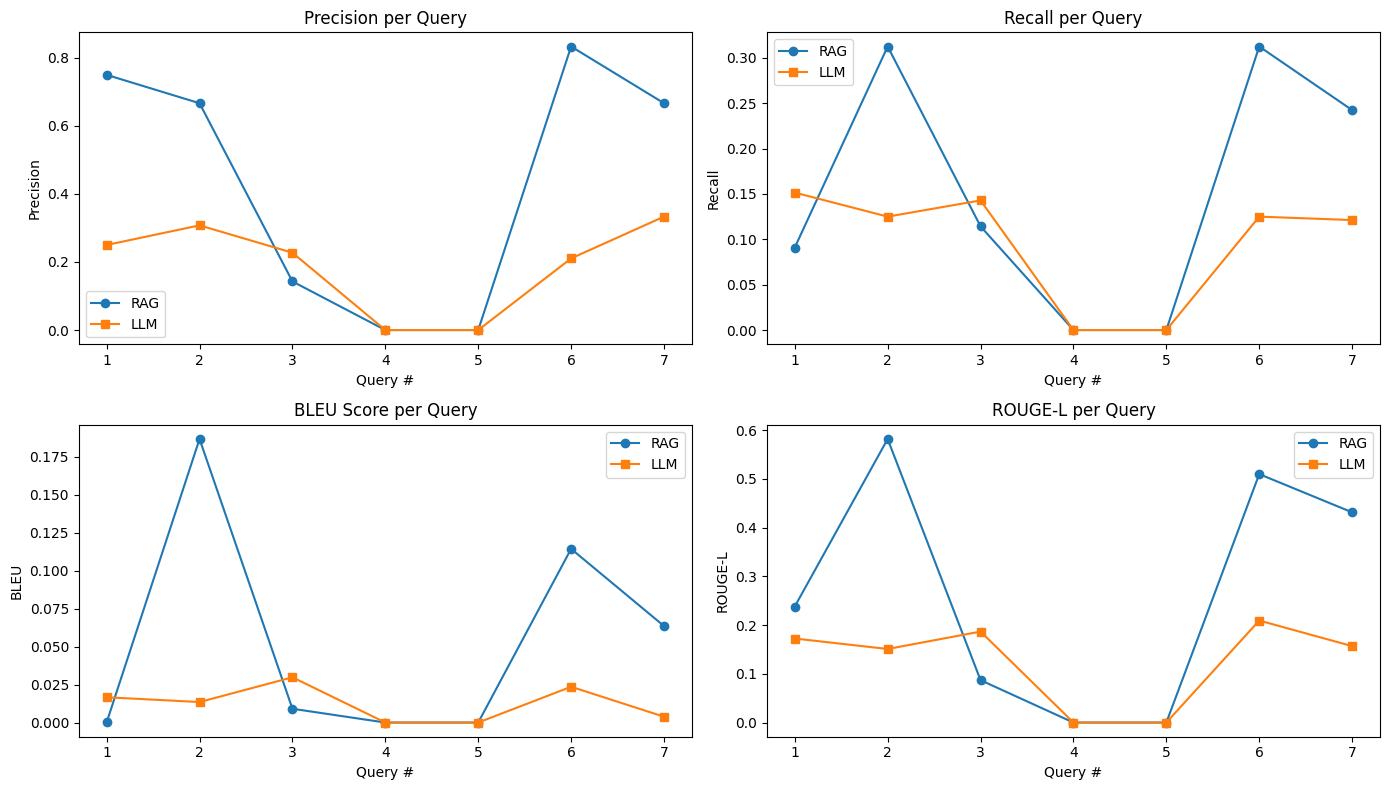

In [ ]:
# ---------- Runtime Q&A Loop ----------
while True:
    query = input("\nEnter your question (or type 'exit' to quit): ")
    if query.lower().strip() == "exit":
        print("\n✅ Exiting... showing comparison graph.")
        plot_comparison()
        break

    # --- Get answers ---
    llm_answer = pure_llm(query)  # Pure LLM baseline
    rag_answer, rag_docs = rag_pipeline(query)

    # --- Show answers ---
    print("\n🔹 Pure LLM Answer:\n", llm_answer)
    print("\n🔹 RAG Answer:\n", rag_answer)

    # --- Evaluate ---
    rag_precision, rag_recall, rag_bleu, rag_r1, rag_rl = evaluate(query, rag_answer, rag_docs)
    llm_precision, llm_recall, llm_bleu, llm_r1, llm_rl = evaluate(query, llm_answer, rag_docs)

    # --- Store results ---
    rag_precision_list.append(rag_precision); rag_recall_list.append(rag_recall)
    rag_bleu_list.append(rag_bleu); rag_rouge1_list.append(rag_r1); rag_rougel_list.append(rag_rl)

    llm_precision_list.append(llm_precision); llm_recall_list.append(llm_recall)
    llm_bleu_list.append(llm_bleu); llm_rouge1_list.append(llm_r1); llm_rougel_list.append(llm_rl)

    # --- Print metrics ---
    print("\n📊 Evaluation Metrics:")
    print(f"   RAG → Precision: {rag_precision:.2f}, Recall: {rag_recall:.2f}, BLEU: {rag_bleu:.2f}, ROUGE-1: {rag_r1:.2f}, ROUGE-L: {rag_rl:.2f}")
    print(f"   LLM → Precision: {llm_precision:.2f}, Recall: {llm_recall:.2f}, BLEU: {llm_bleu:.2f}, ROUGE-1: {llm_r1:.2f}, ROUGE-L: {llm_rl:.2f}")
